## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.baseline.utils import (
    run_study,
    load_baseline_data,
    load_submission,
    make_time_series_split,
)
from storesales.baseline.model_wrappers import (
    DailyMeanModelWrapper,
    ProphetWrapper,
    DayOfWeekMeanModelWrapper,
)
from storesales.baseline.param_suggestions import (
    IntSuggestions,
    FloatSuggestions,
    CategoricalSuggestions,
)
from storesales.baseline.constants import FAMILY_GROUPS, STORES
from storesales.constants import SUBMISSIONS_PATH

## Load && Prepare Data

In [3]:
train_df, test_df, holidays_df = load_baseline_data()

## Prepare SalesPredictor

In [4]:
initial = "760 days"  # train period

### DailyMeanModelWrapper

In [5]:
daily_mean_int_suggestions = [IntSuggestions("window", 3, 60)]

In [6]:
daily_wrapper = DailyMeanModelWrapper(int_suggestions=daily_mean_int_suggestions)

### DayOfWeekMeanModelWrapper

In [7]:
day_of_week_mean_int_suggestions = [
    IntSuggestions("weekdays_window", 3, 50),
    IntSuggestions("weekends_window", 1, 10),
]

In [8]:
day_of_week_wrapper = DayOfWeekMeanModelWrapper(
    int_suggestions=day_of_week_mean_int_suggestions
)

### ProphetWrapper

In [9]:
prophet_int_suggestions = [
    IntSuggestions("n_changepoints", 20, 50),
]
prophet_float_suggestions = [
    FloatSuggestions("changepoint_prior_scale", 0.01, 0.5),
    FloatSuggestions("holidays_prior_scale", 5, 80),
    FloatSuggestions("seasonality_prior_scale", 5, 80),
]
prophet_categorical_suggestions = [
    CategoricalSuggestions("seasonality_mode", ["additive", "multiplicative"]),
]

prophet_base_params = {
    "daily_seasonality": False,
    "weekly_seasonality": True,
    "yearly_seasonality": True,
    "uncertainty_samples": False,
    "holidays": holidays_df,
}

In [10]:
prophet_wrapper = ProphetWrapper(
    initial=initial,
    extra_regressors=["dcoilwtico"],
    int_suggestions=prophet_int_suggestions,
    float_suggestions=prophet_float_suggestions,
    categorical_suggestions=prophet_categorical_suggestions,
    model_base_params=prophet_base_params,
)

### SalesPredictor

In [11]:
model_wrappers = {
    DailyMeanModelWrapper.__name__: daily_wrapper,
    DayOfWeekMeanModelWrapper.__name__: day_of_week_wrapper,
    # ProphetWrapper.__name__: prophet_wrapper,  # disabled due to long training time
}

optuna_optimize_kwargs = dict(
    n_trials=100,
    show_progress_bar=False,
    timeout=45,
)

outer_cutoffs_dates = [
    "2016-08-16",
    "2016-09-10",
    "2016-10-01",
    "2016-10-25",
    "2016-11-18",
    "2016-12-10",
    "2017-01-01",
    "2017-01-23",
    "2017-02-20",
    "2017-03-12",
    "2017-04-04",
    "2017-05-15",
    "2017-07-31",
]
outer_cutoffs = [pd.Timestamp(date) for date in outer_cutoffs_dates]
predictor = SalesPredictor(
    model_wrappers=model_wrappers,
    family_groups=FAMILY_GROUPS,
    outer_cutoffs=outer_cutoffs,
    inner_cutoffs=[-180, -49, -33, -17],
    outer_cv=TimeSeriesSplit(n_splits=3, test_size=16),
    optuna_optimize_kwargs=optuna_optimize_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=2,
)

## Run Study

In [12]:
dataset = make_time_series_split(train_df, predictor.outer_cutoffs, 16)

100%|██████████| 1782/1782 [00:25<00:00, 70.71it/s]


In [14]:
sales_predictor = run_study(STORES, dataset, predictor)

Family Group: ('AUTOMOTIVE', 'CLEANING', 'DELI', 'GROCERY I', 'PERSONAL CARE', 'PREPARED FOODS'):


100%|██████████| 4/4 [02:03<00:00, 30.99s/it]


RMSLE: 0.4151330495425224
Family Group: ('BEAUTY', 'BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'EGGS', 'POULTRY'):


100%|██████████| 4/4 [01:59<00:00, 29.98s/it]


RMSLE: 0.4310777151693375
Family Group: ('CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'PRODUCE'):


100%|██████████| 4/4 [01:35<00:00, 23.82s/it]


RMSLE: 0.4907936734599788
Family Group: ('BABY CARE',):


100%|██████████| 2/2 [00:37<00:00, 18.92s/it]


RMSLE: 0.24378712844538505
Family Group: ('BOOKS',):


100%|██████████| 2/2 [00:39<00:00, 19.53s/it]


RMSLE: 0.19223053036542245
Family Group: ('FROZEN FOODS',):


100%|██████████| 2/2 [00:42<00:00, 21.29s/it]


RMSLE: 0.6291502139753743
Family Group: ('GROCERY II',):


100%|██████████| 2/2 [00:41<00:00, 20.52s/it]


RMSLE: 0.6398130556677811
Family Group: ('HARDWARE',):


100%|██████████| 2/2 [00:42<00:00, 21.35s/it]


RMSLE: 0.5498894490023553
Family Group: ('HOME AND KITCHEN I',):


100%|██████████| 2/2 [00:48<00:00, 24.15s/it]


RMSLE: 0.626975873184047
Family Group: ('HOME AND KITCHEN II',):


100%|██████████| 2/2 [00:39<00:00, 19.56s/it]


RMSLE: 0.5222815533278694
Family Group: ('HOME APPLIANCES',):


100%|██████████| 2/2 [00:38<00:00, 19.22s/it]


RMSLE: 0.29022769050199515
Family Group: ('LAWN AND GARDEN',):


100%|██████████| 2/2 [00:40<00:00, 20.16s/it]


RMSLE: 0.5047784008031405
Family Group: ('LINGERIE',):


100%|██████████| 2/2 [00:41<00:00, 20.70s/it]


RMSLE: 0.6671375476800754
Family Group: ('LIQUOR,WINE,BEER',):


100%|██████████| 2/2 [00:40<00:00, 20.41s/it]


RMSLE: 0.8907975720007685
Family Group: ('MAGAZINES',):


100%|██████████| 2/2 [00:46<00:00, 23.36s/it]


RMSLE: 0.5529122042173161
Family Group: ('MEATS',):


100%|██████████| 2/2 [00:43<00:00, 21.82s/it]


RMSLE: 0.42403522692058
Family Group: ('SCHOOL AND OFFICE SUPPLIES',):


100%|██████████| 2/2 [00:39<00:00, 19.56s/it]


RMSLE: 0.6350028890464594
Family Group: ('SEAFOOD',):


100%|██████████| 2/2 [00:44<00:00, 22.03s/it]

RMSLE: 0.536651802217207


Total RMSLE: 0.48265750807232755 



## Analyze Loss Results

In [15]:
def make_plot(data_dict, loss_sample_name, title):
    x_name = "outer cv fold start"
    y_name = "loss"

    for i_group, samples in enumerate(data_dict.values()):
        plot_data = [
            [outer_cutoffs_dates[sample], loss]
            for sample, losses in samples[loss_sample_name].items()
            for loss in losses
        ]

        df = pd.DataFrame(plot_data, columns=[x_name, y_name])

        fig, ax = plt.subplots(figsize=(16, 8))
        sns.boxplot(x=x_name, y=y_name, data=df, showmeans=False, ax=ax)

        means = df.groupby(x_name)[y_name].mean().reset_index()
        sns.pointplot(
            x=x_name,
            y=y_name,
            data=means,
            color="red",
            linestyle="none",
            markers="o",
            estimator=np.mean,
            errorbar=None,
            ax=ax,
        )

        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        ax.ticklabel_format(style="plain", axis="y")

        ax.set_title(f"{title} - Group {FAMILY_GROUPS[i_group]}")
        plt.xticks(rotation=90)
        plt.tight_layout()

        plt.show()

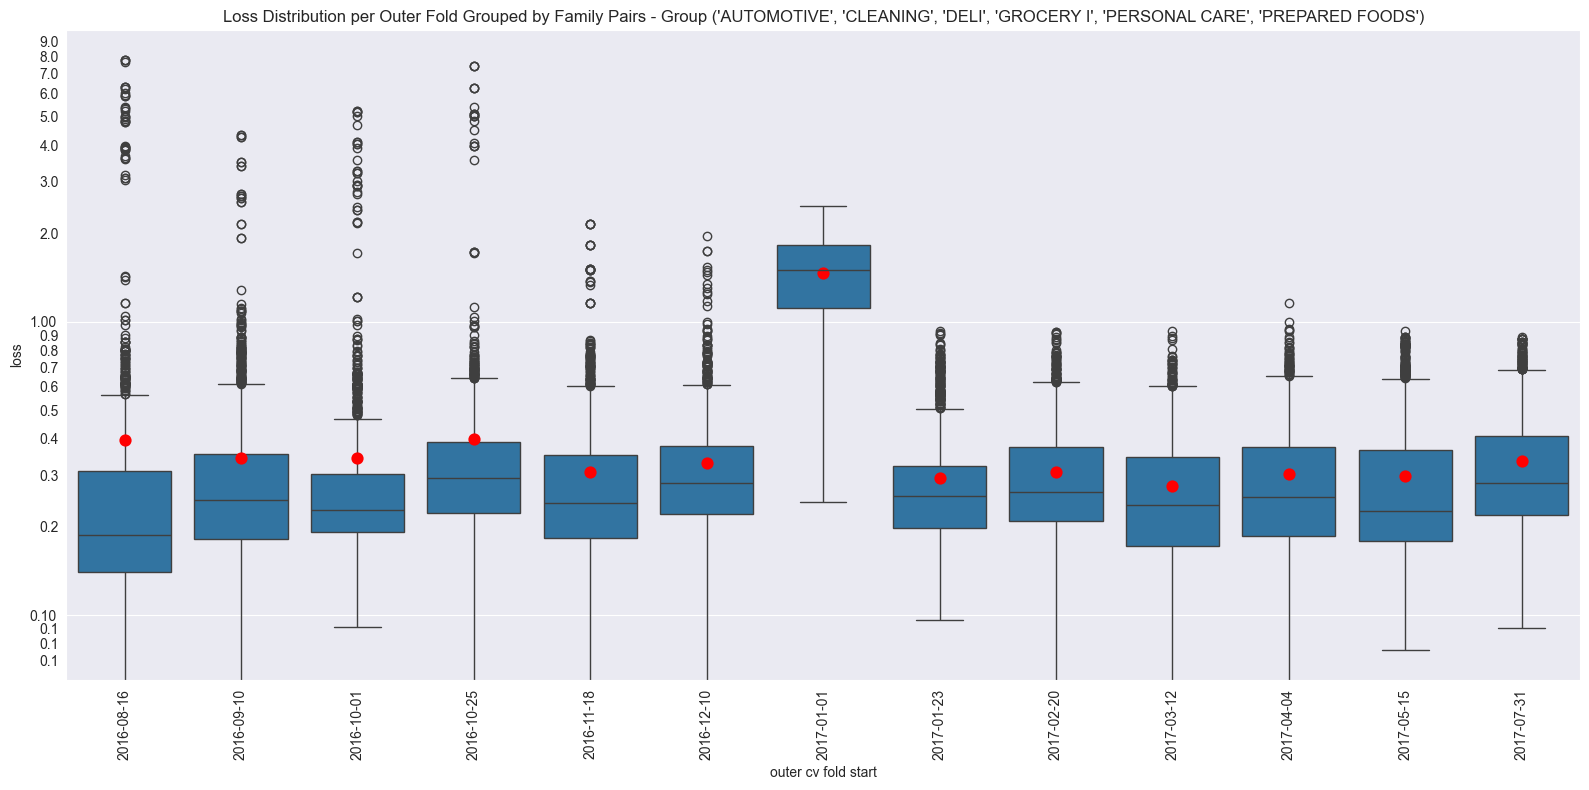

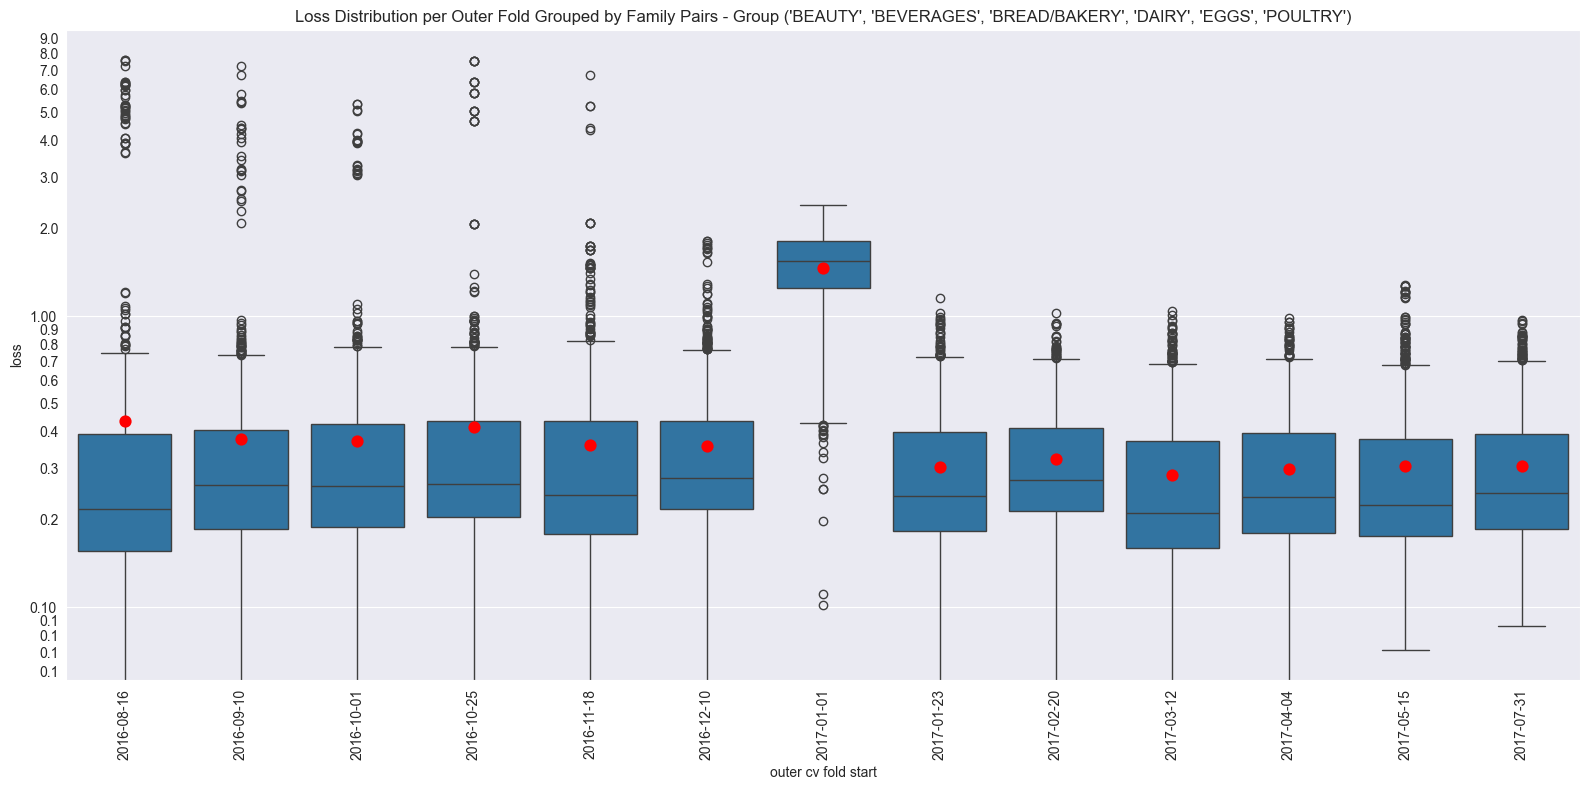

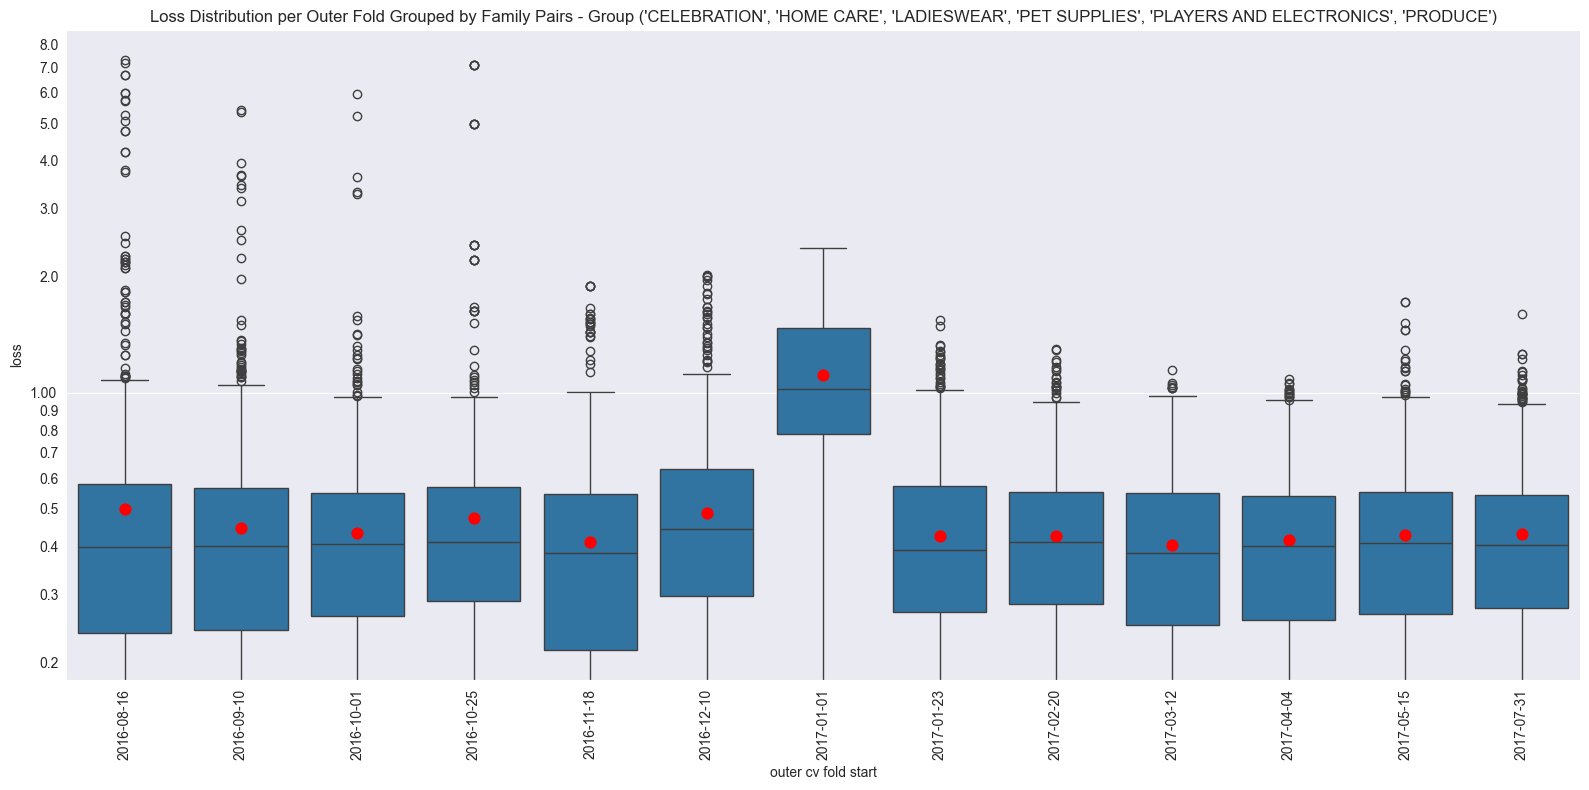

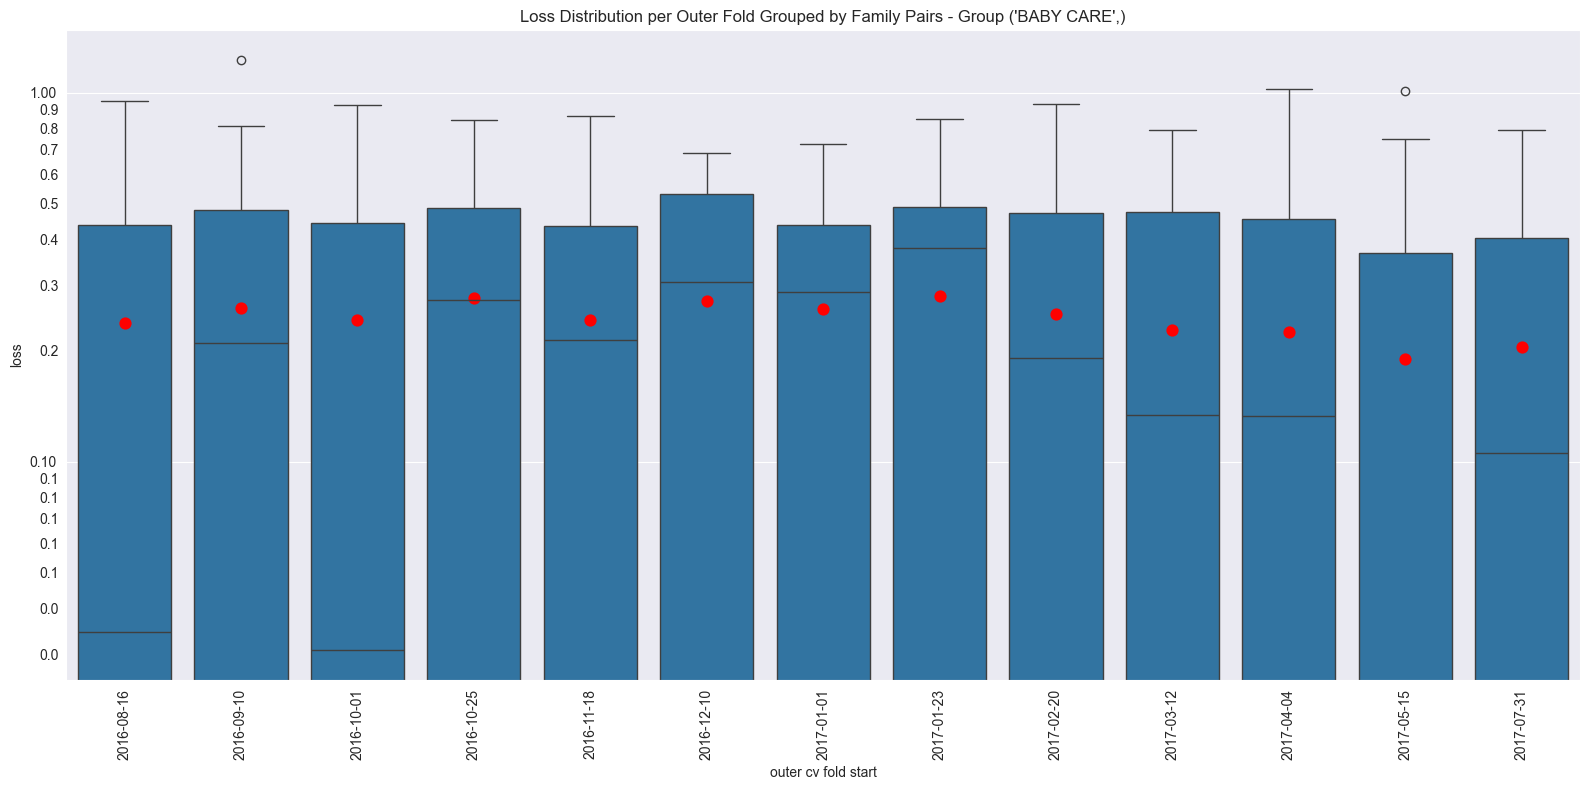

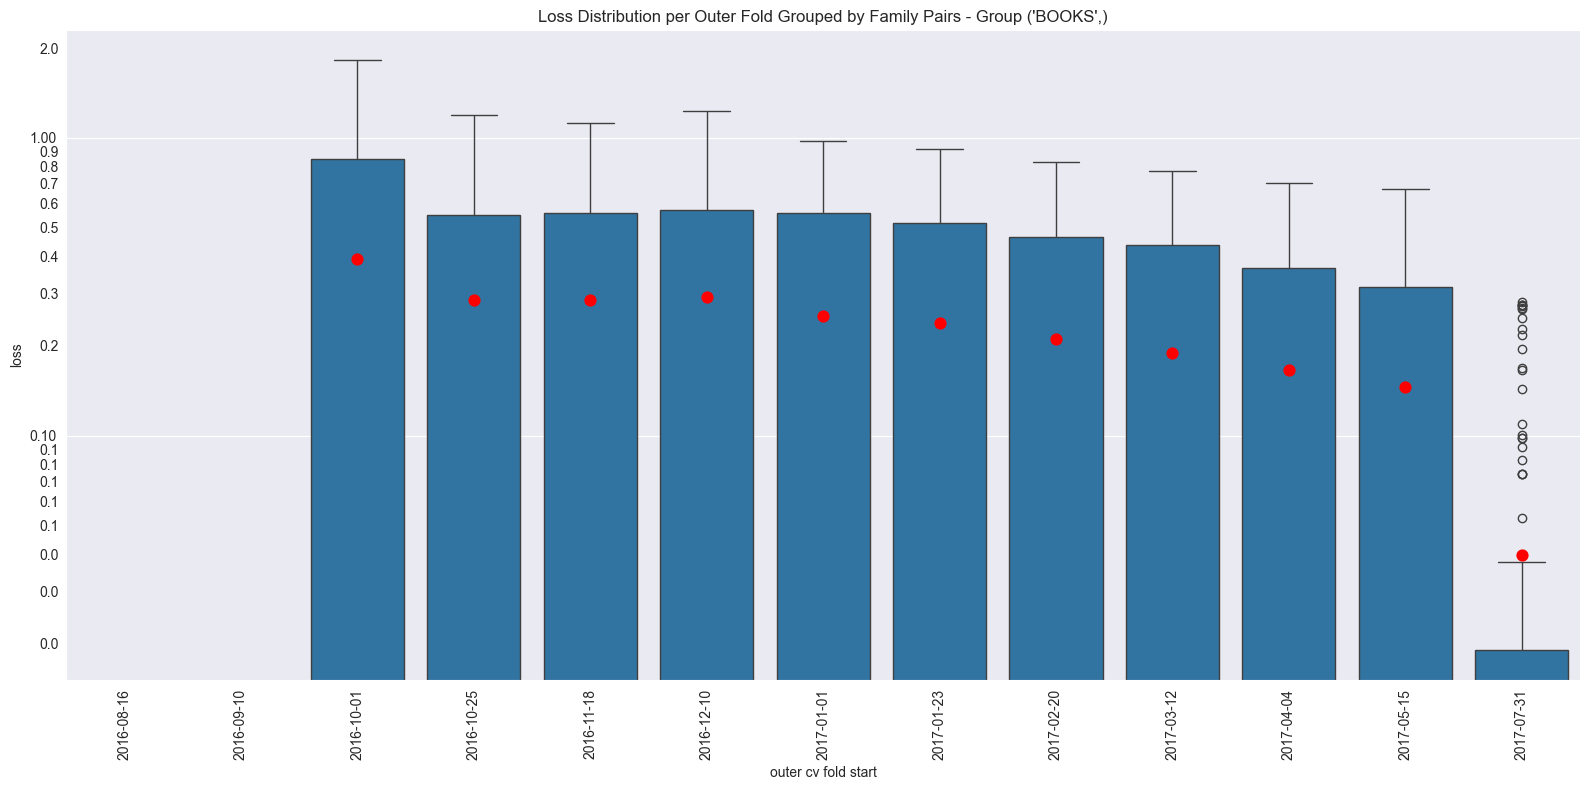

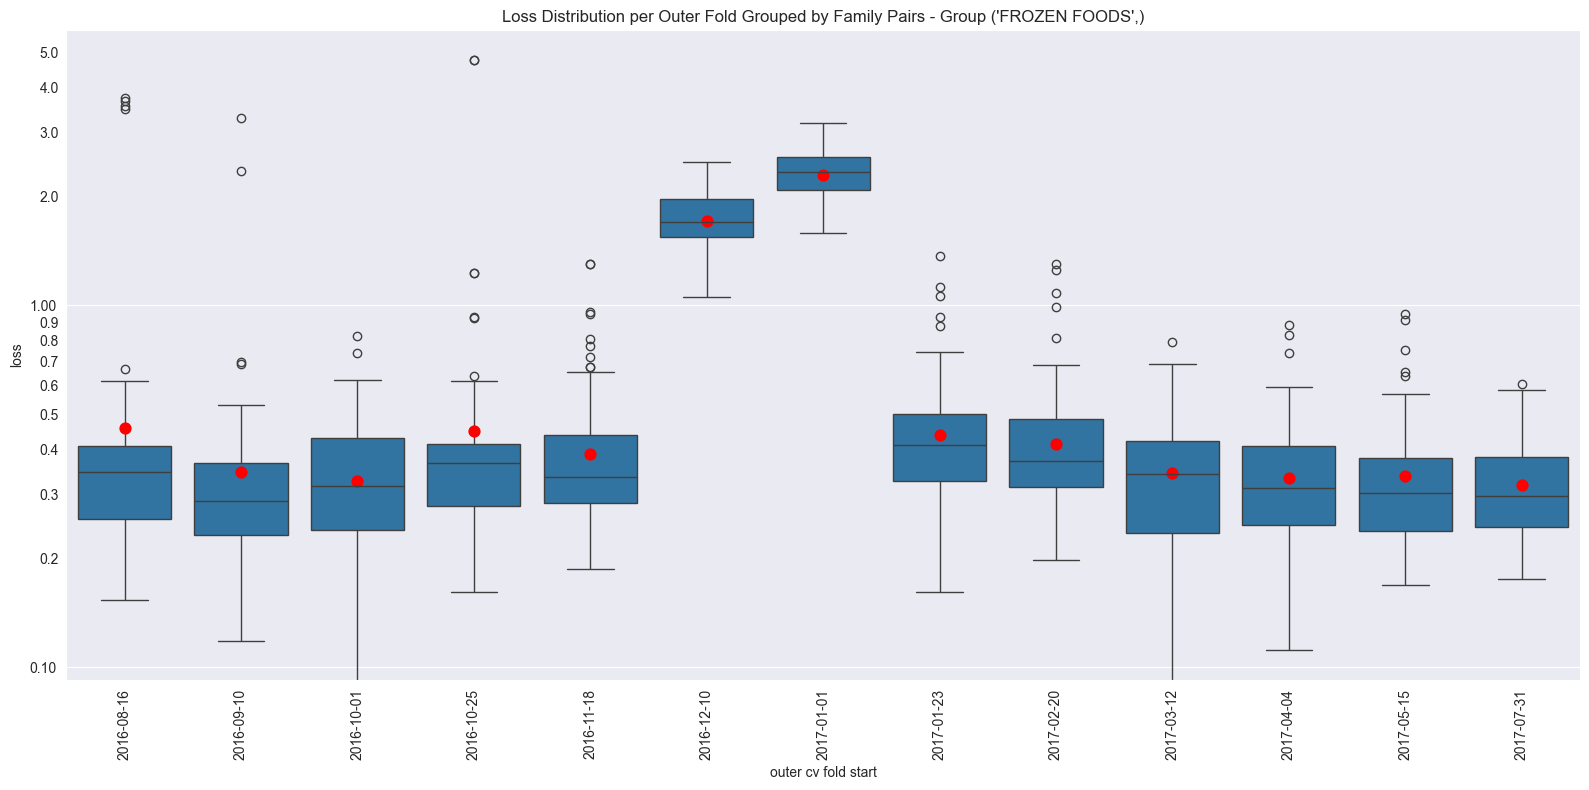

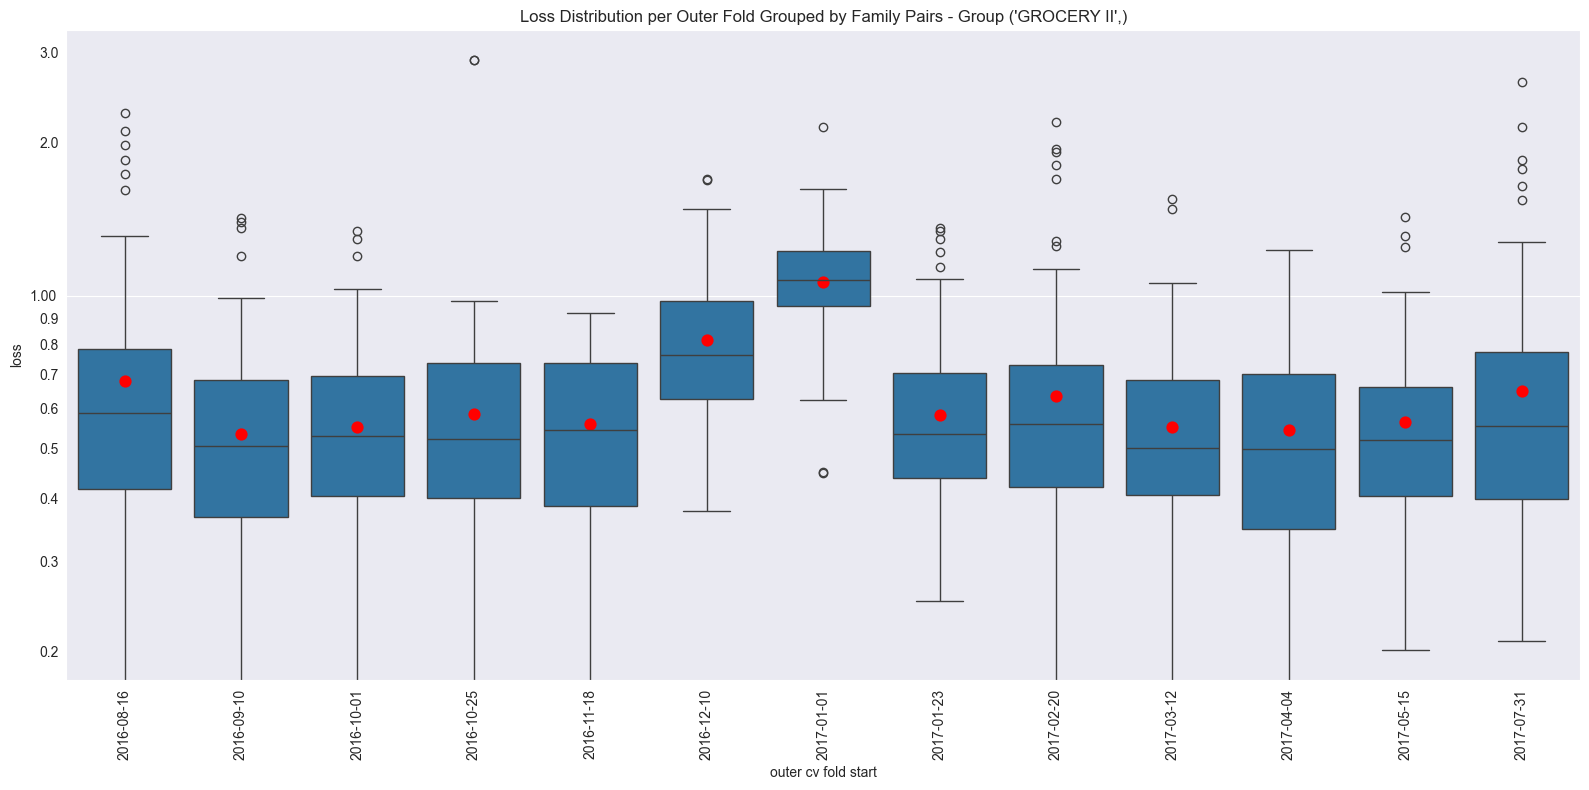

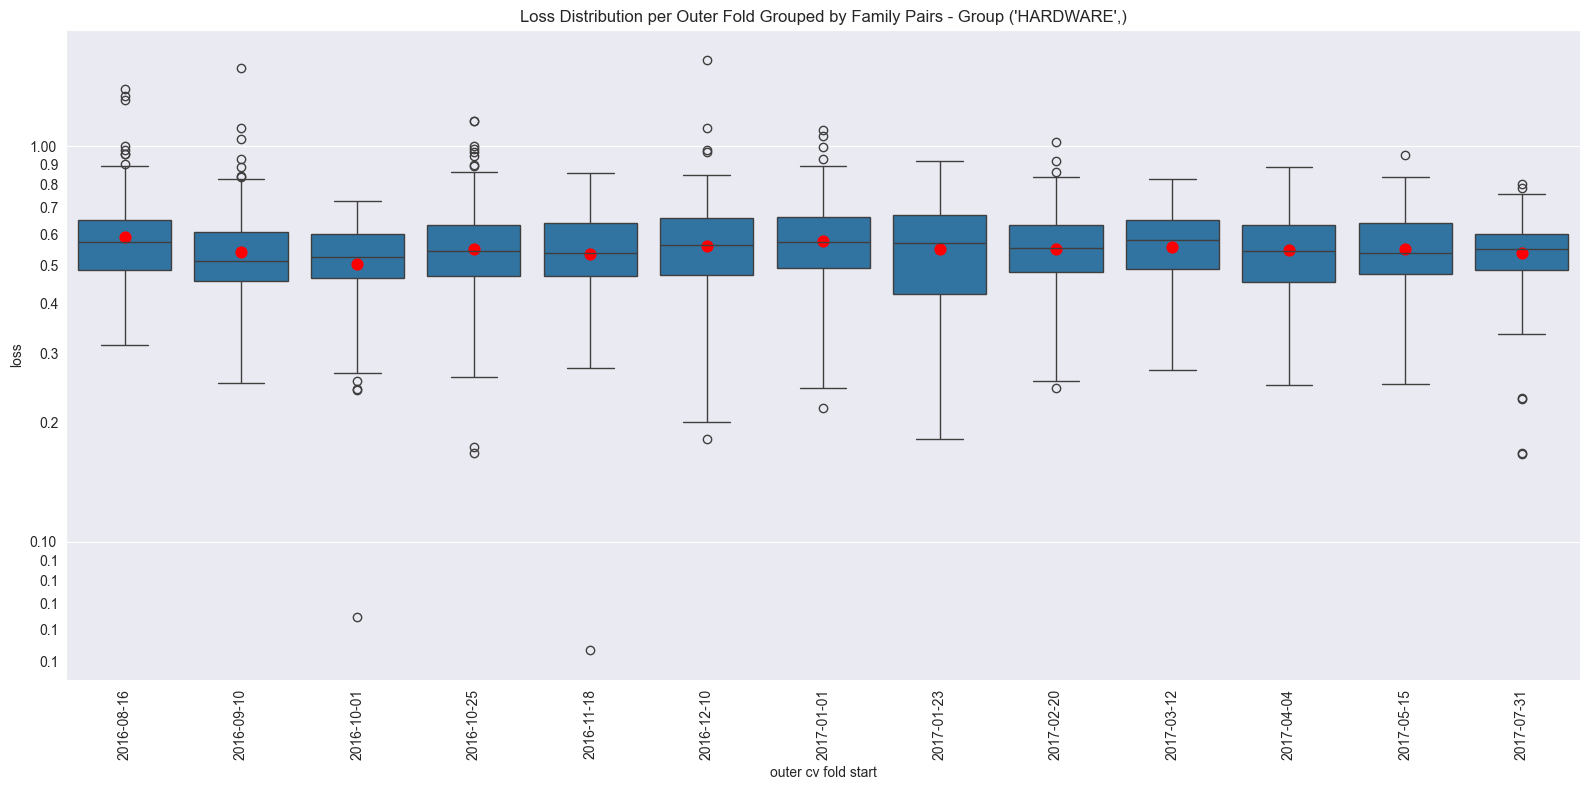

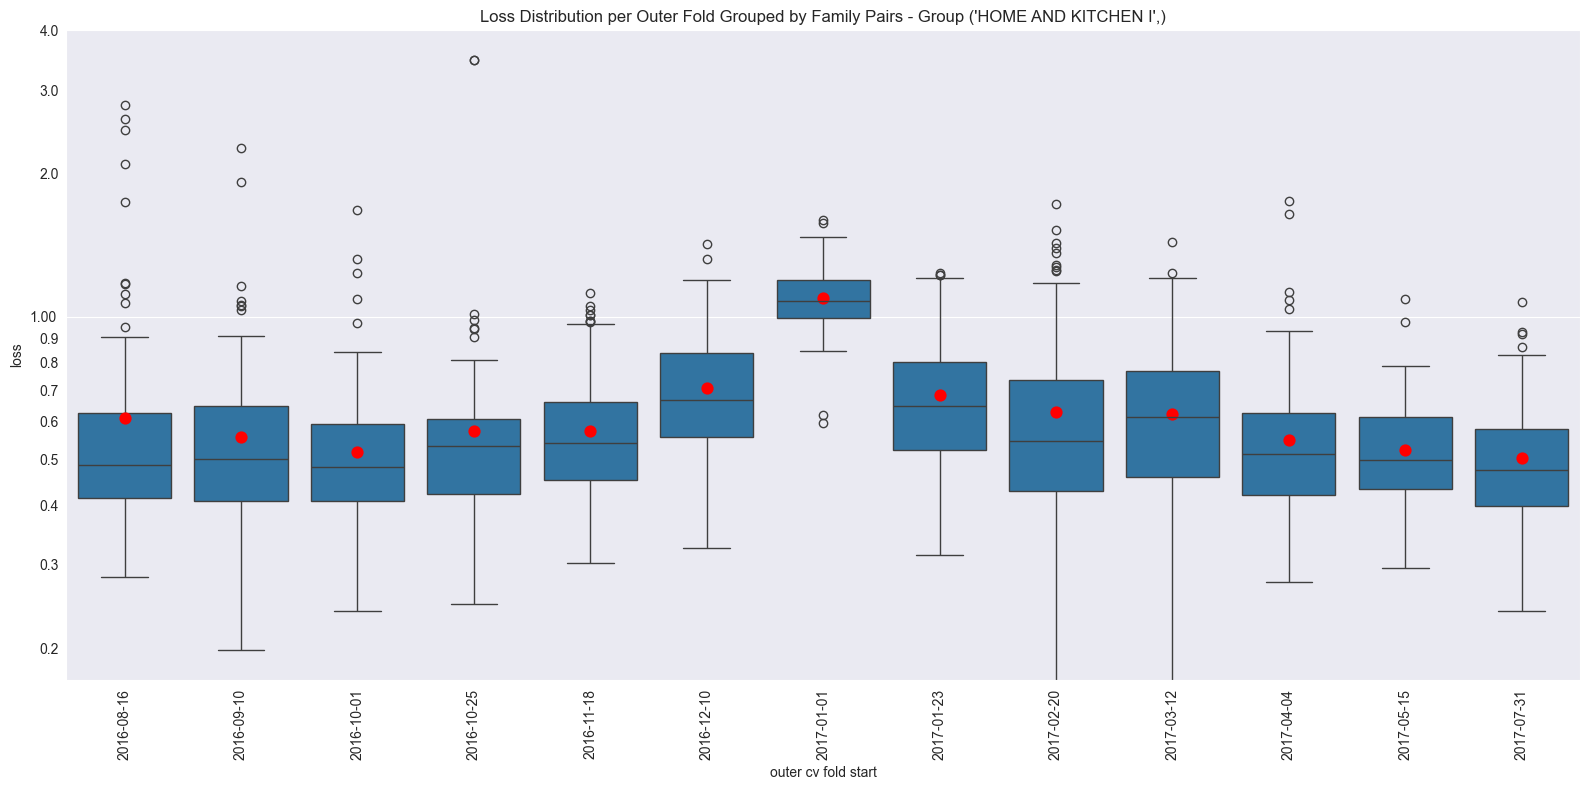

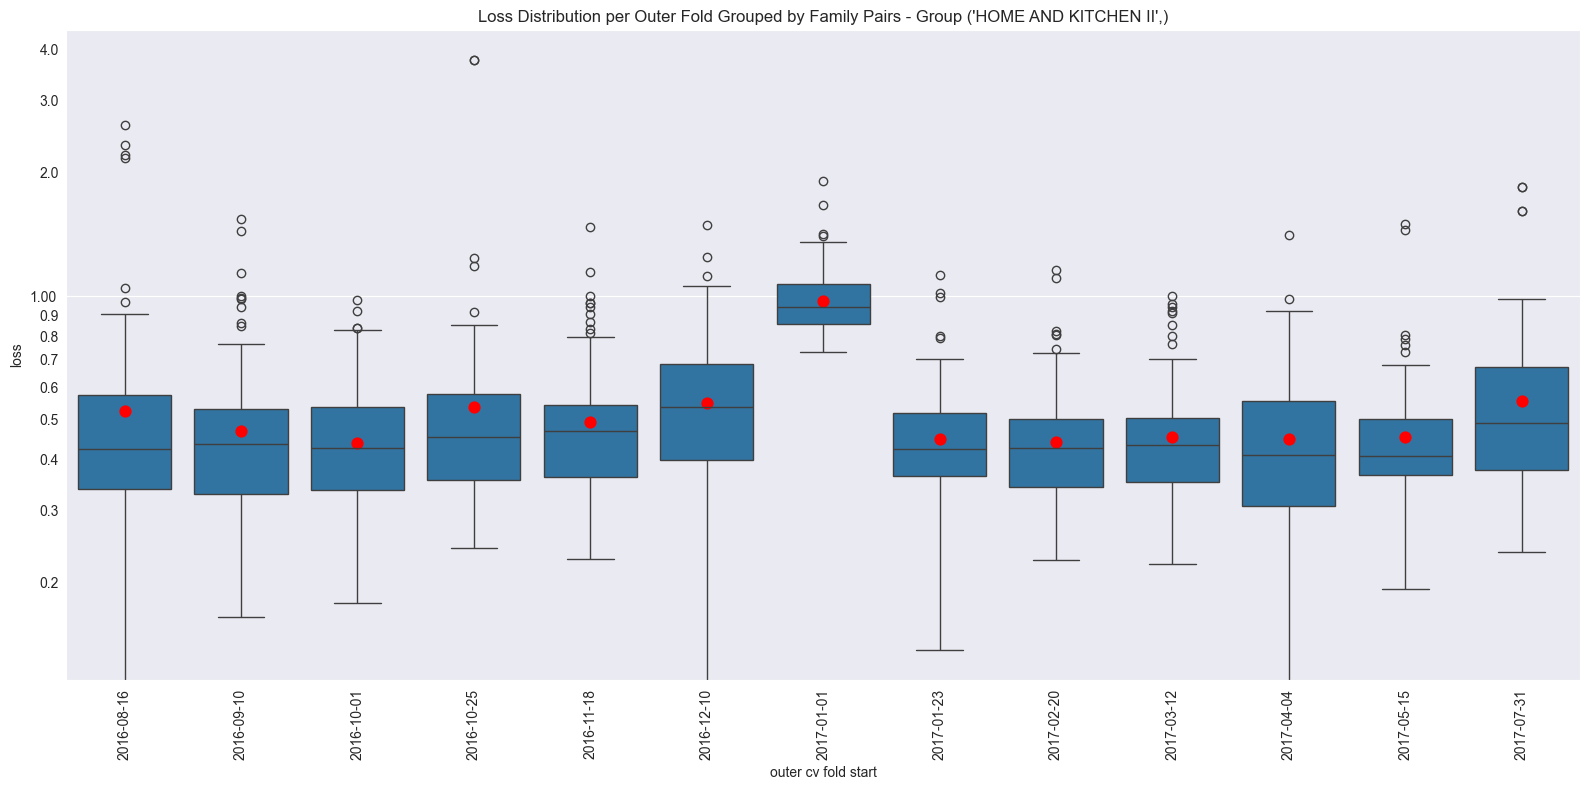

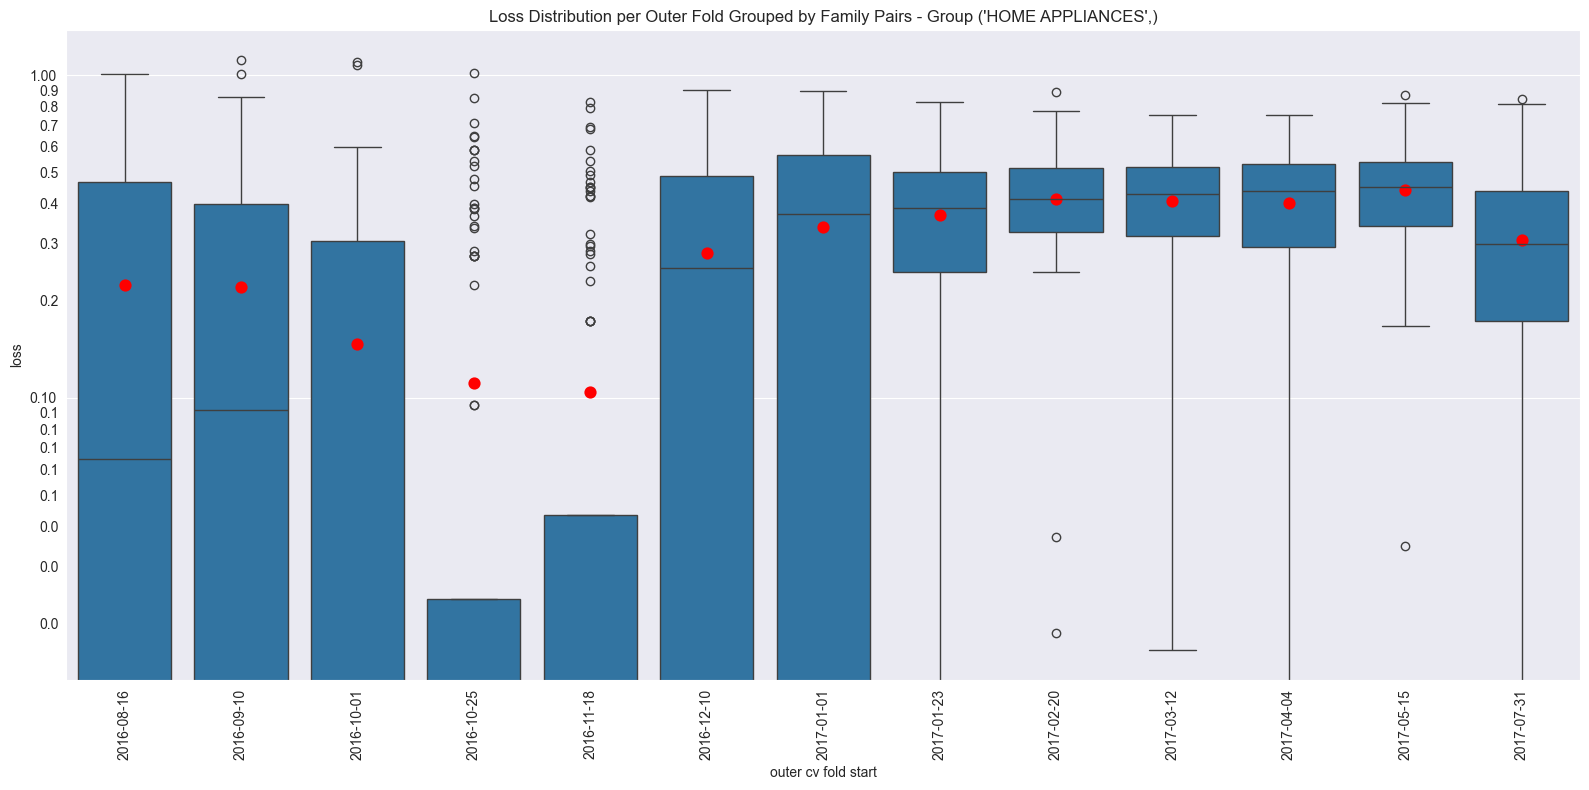

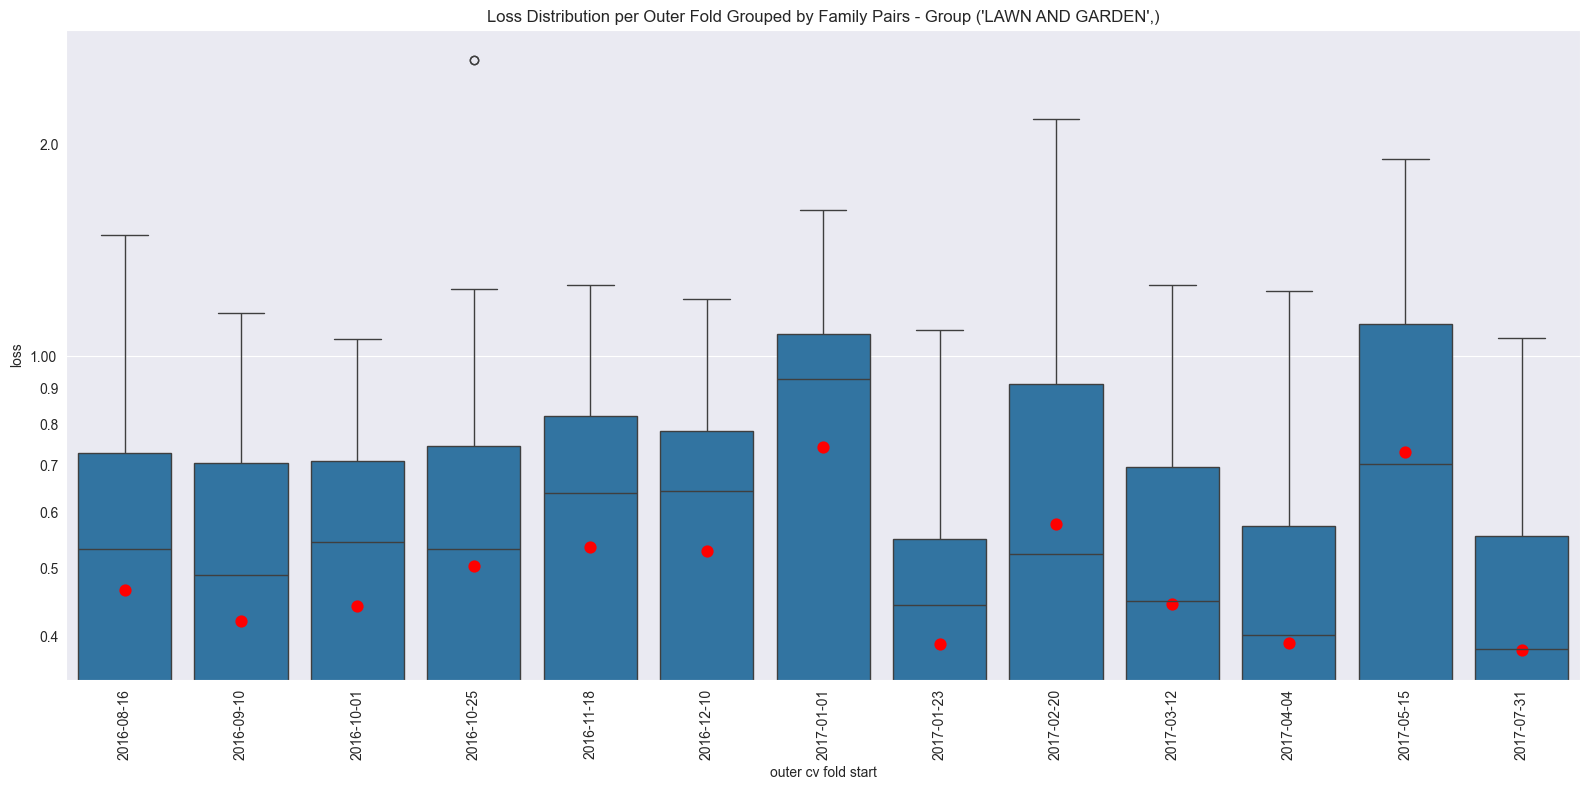

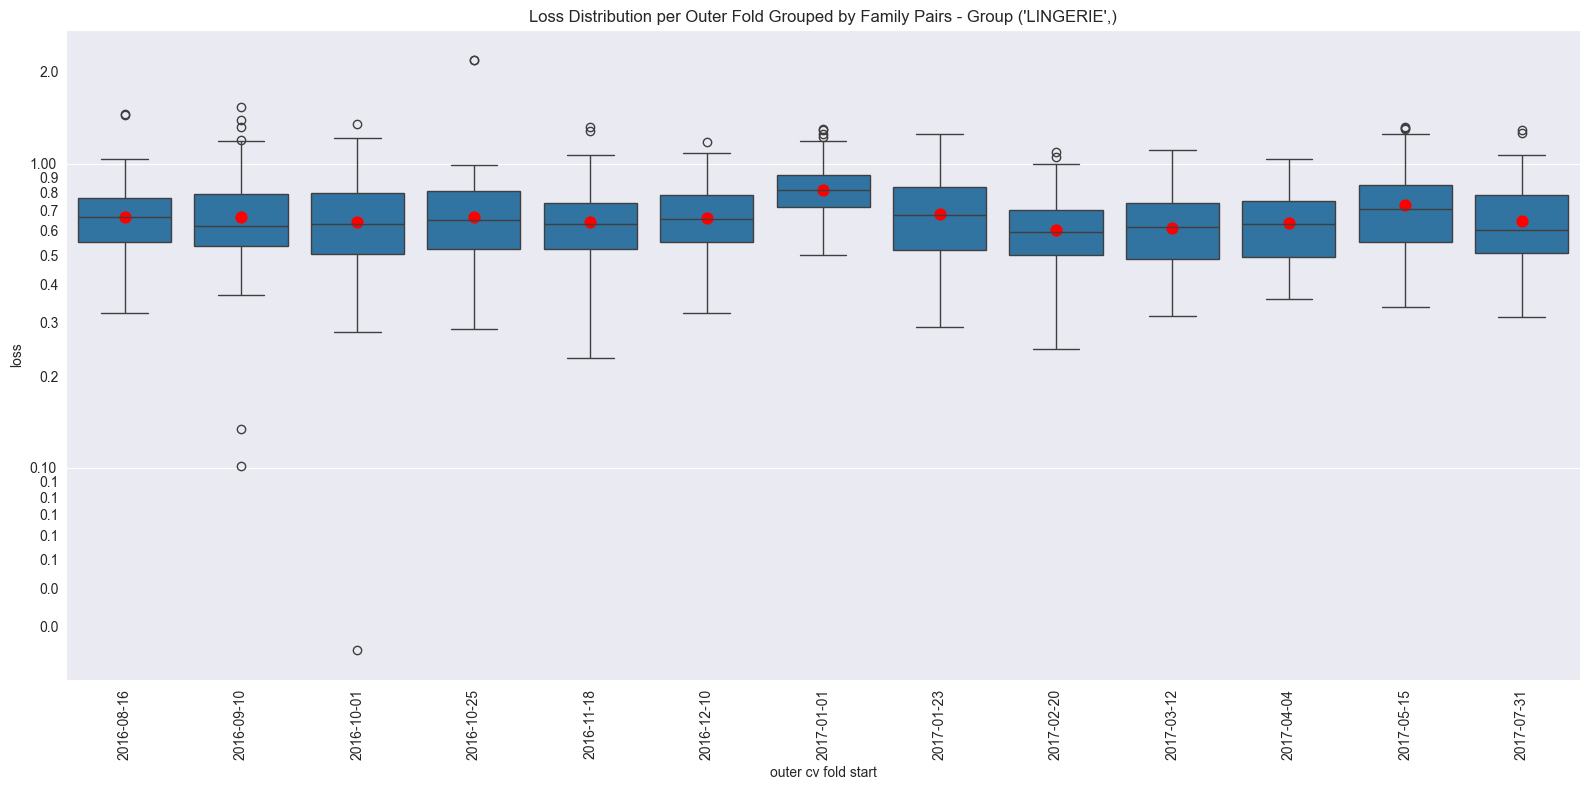

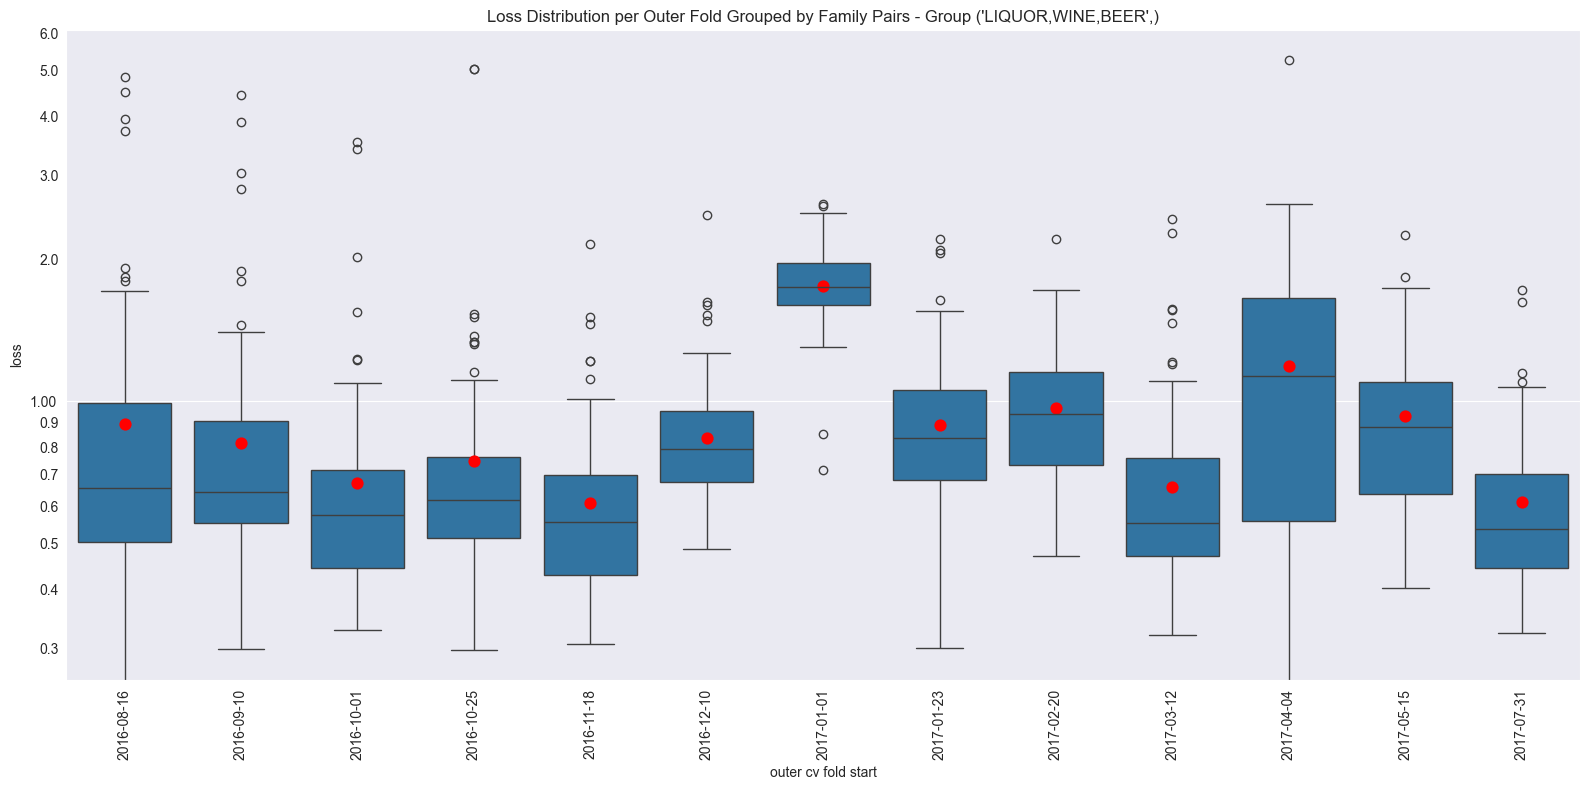

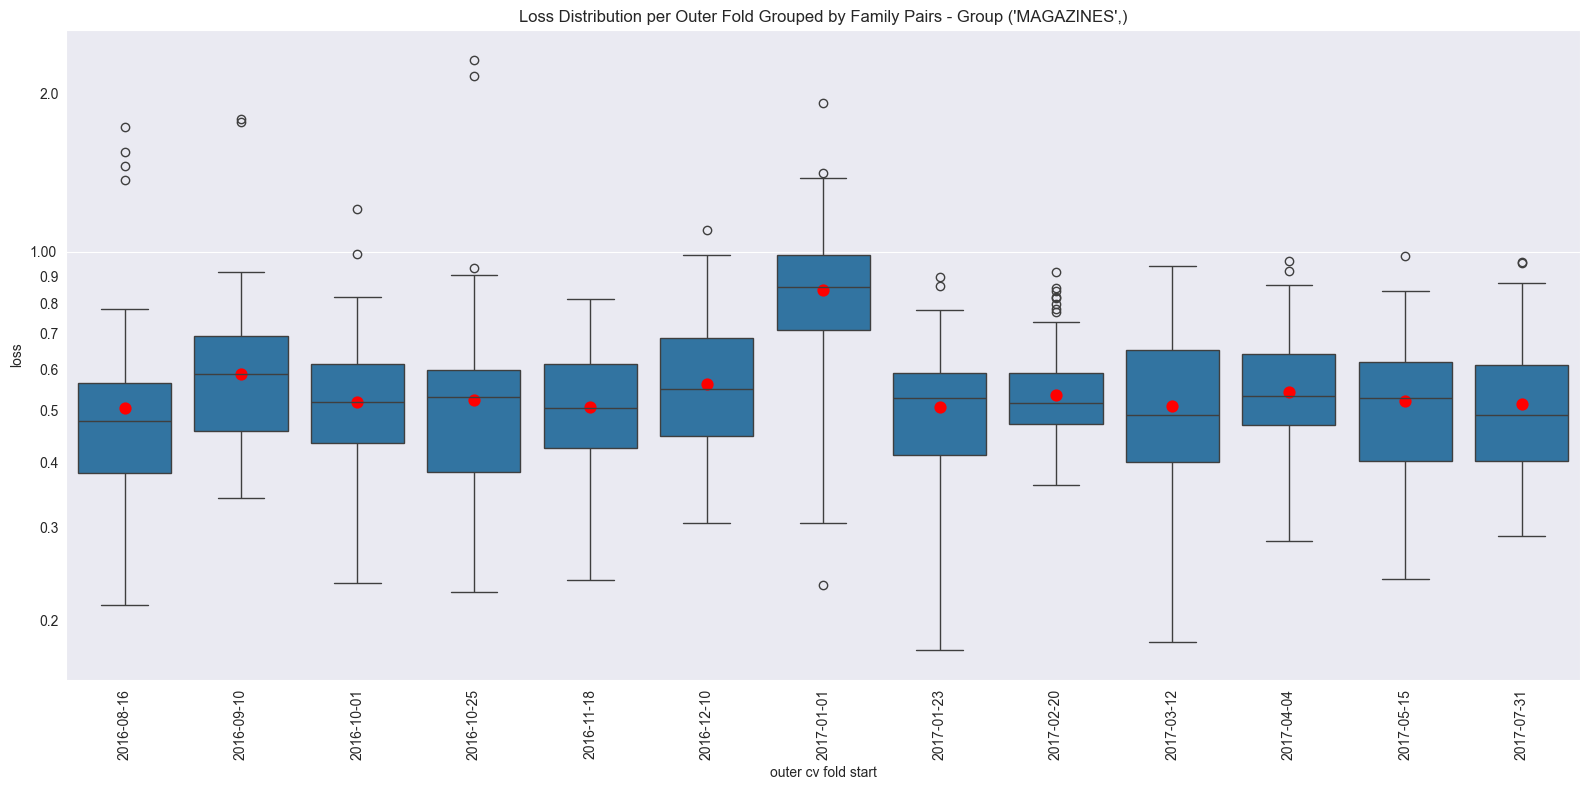

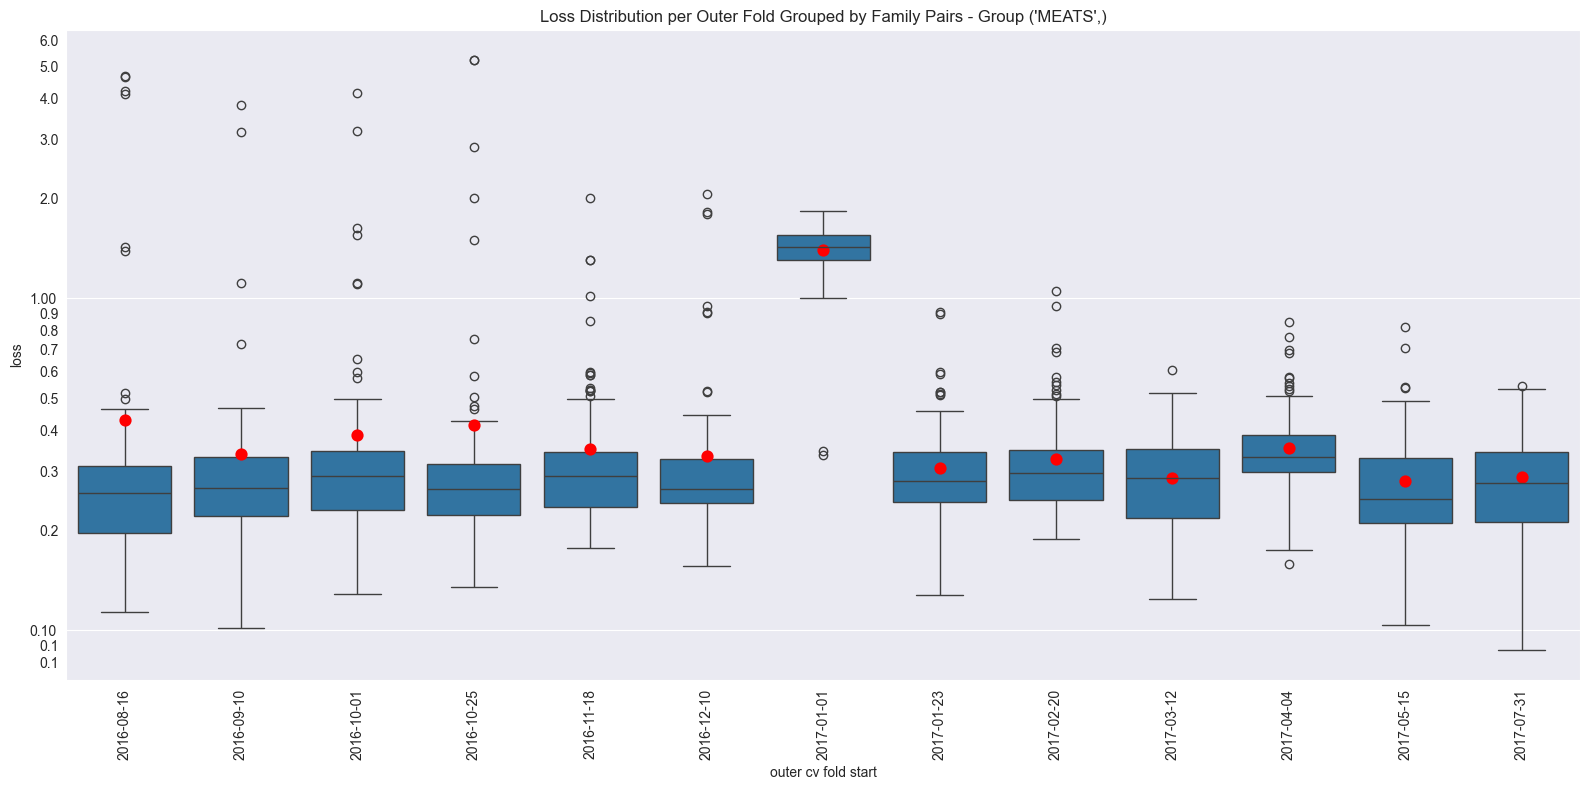

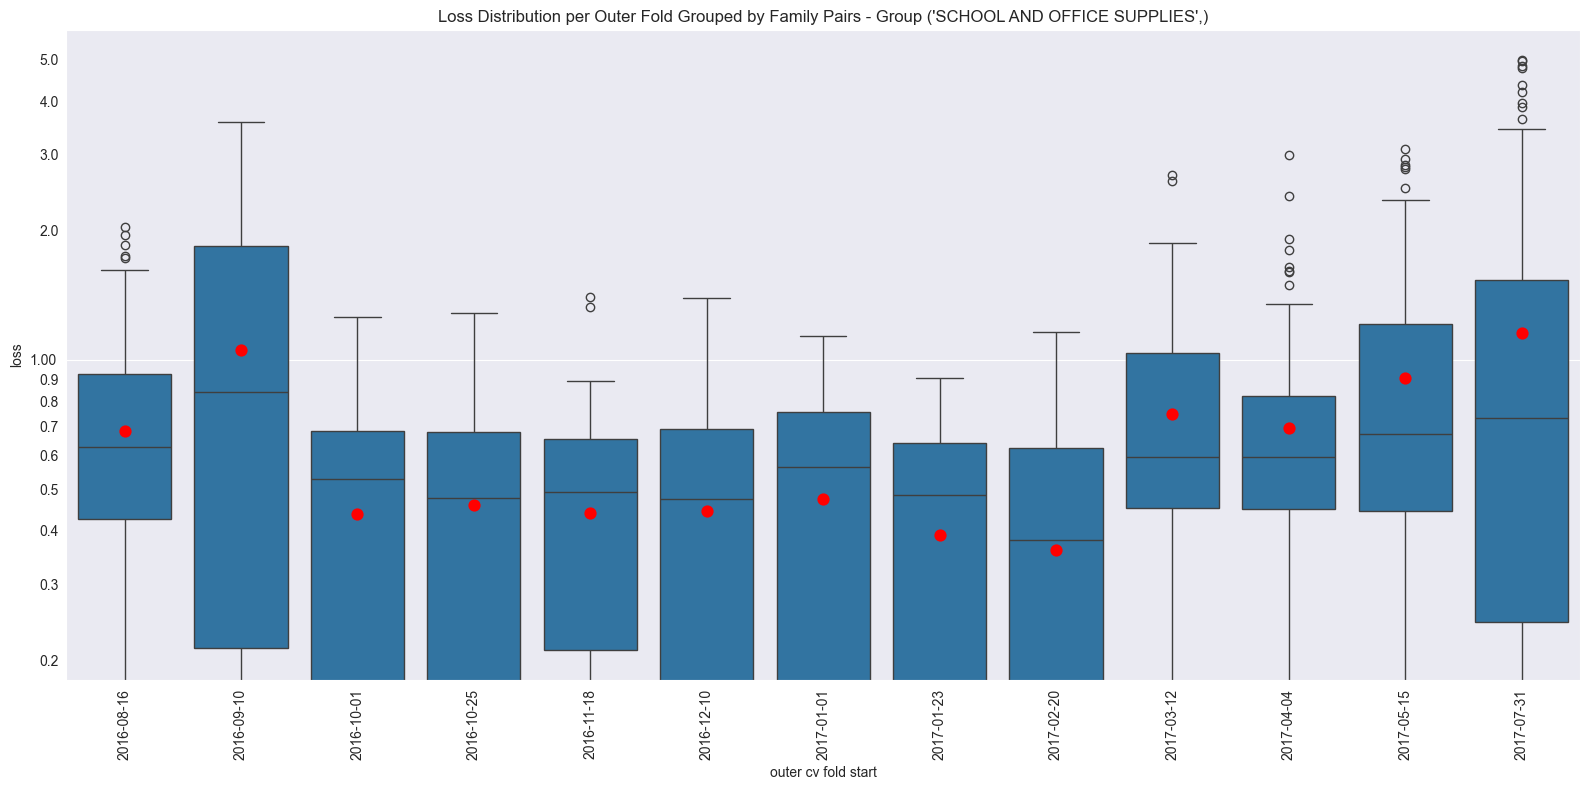

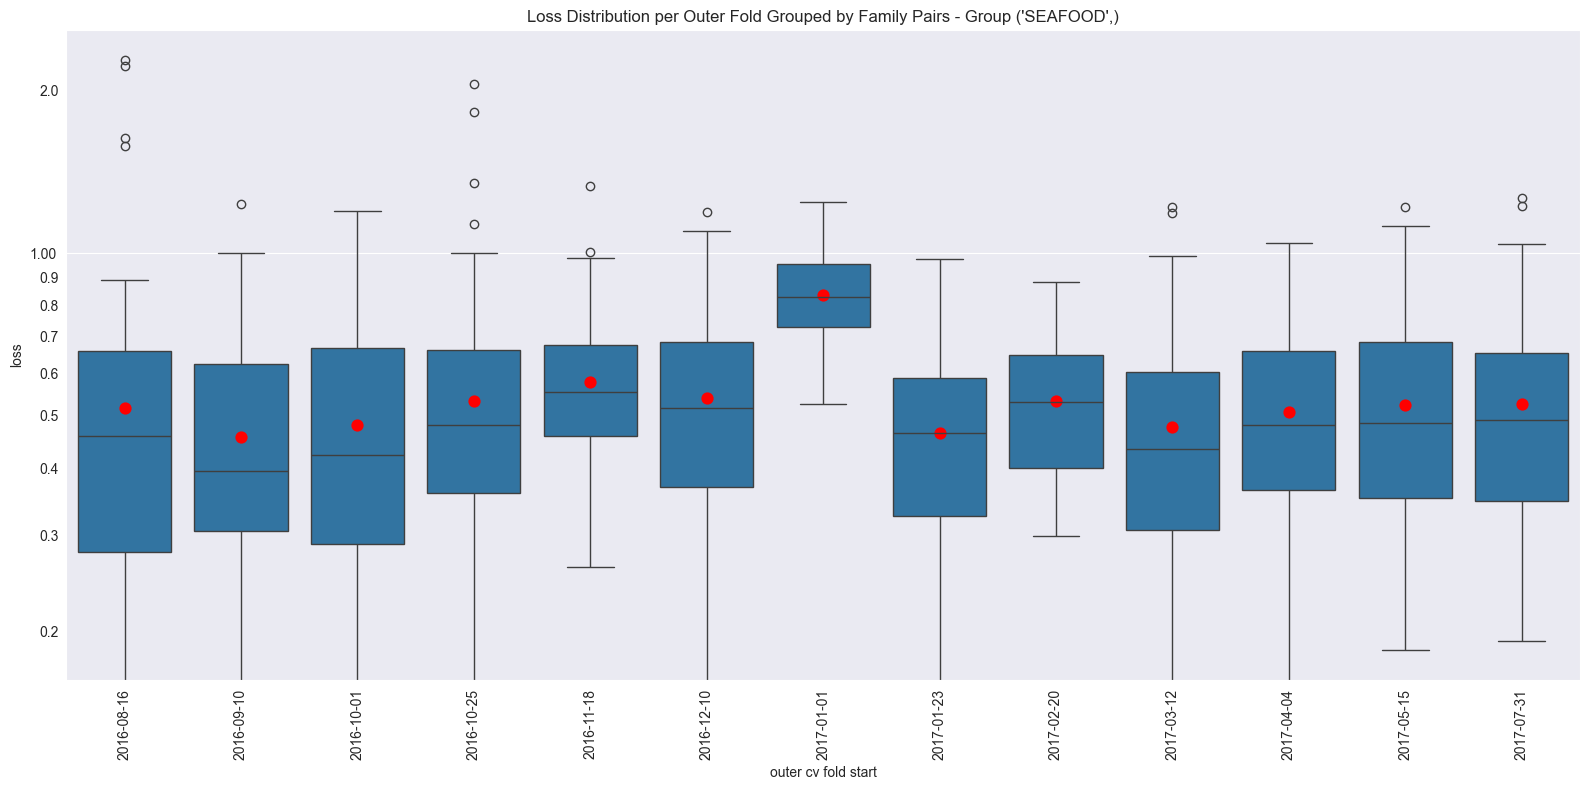

In [16]:
plot_title = "Loss Distribution per Outer Fold Grouped by Family Pairs"
make_plot(sales_predictor.tune_loss_storage, "fold_losses", plot_title)

## Make Submission
### Train Predictor

In [18]:
sales_predictor.fit(train_df, initial)

100%|██████████| 1782/1782 [02:18<00:00, 12.88it/s]


### Predict && Save Submission

In [19]:
submission = load_submission()

In [20]:
tuned_submission = sales_predictor.predict(test_df, submission)

100%|██████████| 1782/1782 [00:08<00:00, 218.61it/s]


In [21]:
submission_file_path = os.path.join(SUBMISSIONS_PATH, "test_more_cutoffs_cv_copy_1.csv")
tuned_submission.to_csv(submission_file_path)